In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.sparse import hstack, csr_matrix
import ast

# Load Data
train_df = pd.read_csv('/Users/radhikapanchal/Downloads/Dataset 2/Train.csv')
test_df = pd.read_csv('/Users/radhikapanchal/Downloads/Dataset 2/Test.csv')
train_df.dropna(inplace=True)


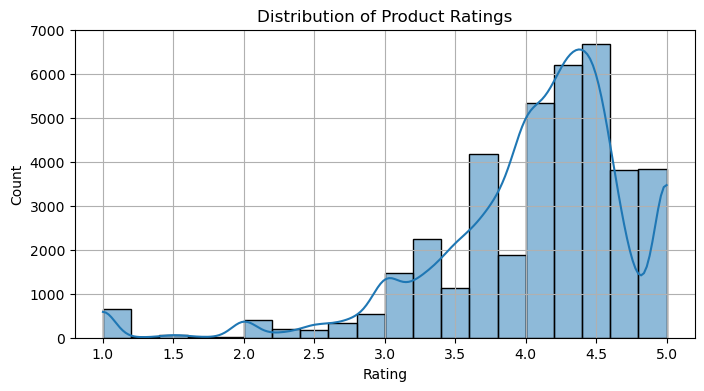

count    39194.000000
mean         4.039498
std          0.726130
min          1.000000
25%          3.700000
50%          4.200000
75%          4.500000
max          5.000000
Name: Product_Rating, dtype: float64


In [2]:
plt.figure(figsize=(8, 4))
sns.histplot(train_df['Product_Rating'], bins=20, kde=True)
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print(train_df['Product_Rating'].describe())


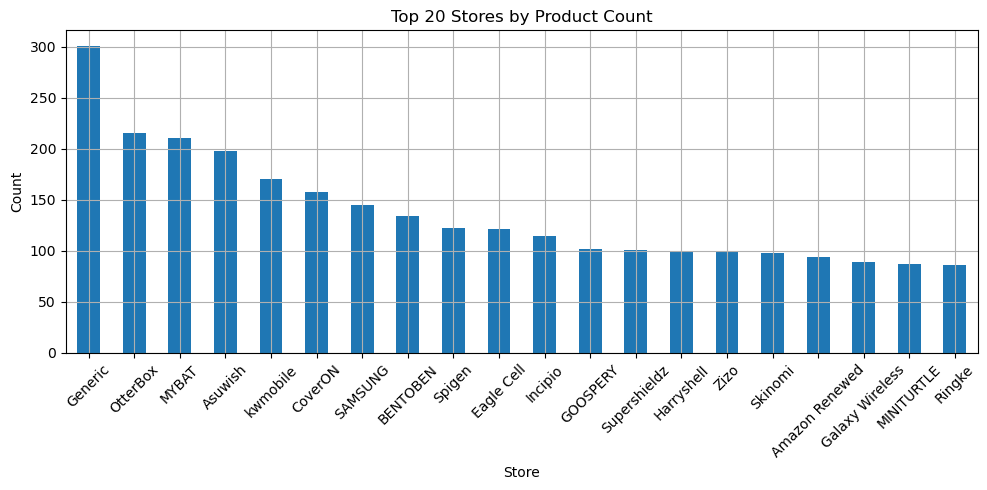

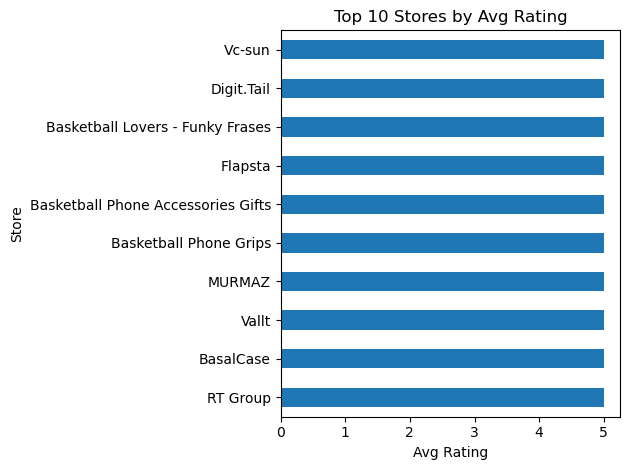

In [3]:
top_stores = train_df['Store'].value_counts().head(20)
top_stores.plot(kind='bar', figsize=(10, 5), title='Top 20 Stores by Product Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

store_rating = train_df.groupby("Store")["Product_Rating"].mean().sort_values(ascending=False).head(10)
store_rating.plot(kind='barh', title='Top 10 Stores by Avg Rating')
plt.xlabel('Avg Rating')
plt.tight_layout()
plt.show()


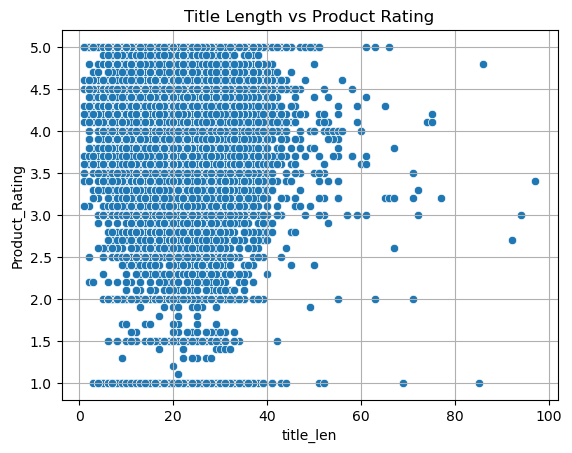

In [4]:
train_df["title_len"] = train_df["Title"].apply(lambda x: len(x.split()))
train_df["details_len"] = train_df["Details"].apply(lambda x: len(x.split()))

sns.scatterplot(x="title_len", y="Product_Rating", data=train_df)
plt.title("Title Length vs Product Rating")
plt.grid(True)
plt.show()


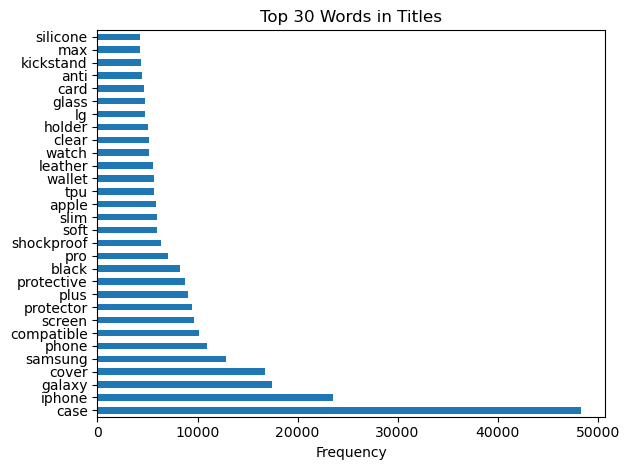

In [5]:
cv = CountVectorizer(stop_words='english', max_features=30)
X = cv.fit_transform(train_df["Title"])
word_freq = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out()).sum().sort_values(ascending=False)

word_freq.plot(kind='barh', title='Top 30 Words in Titles')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()


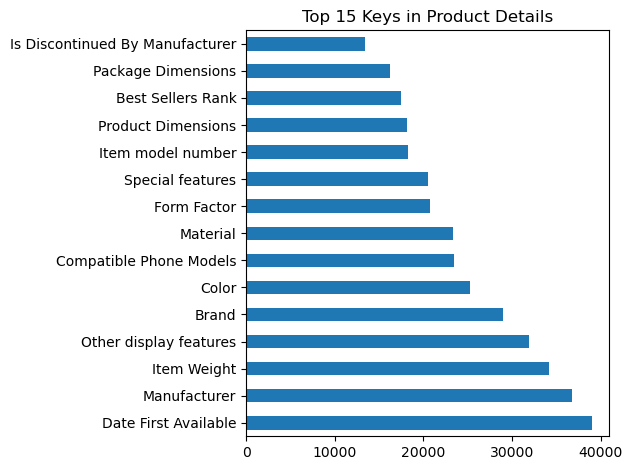

In [6]:
def extract_keys(detail):
    try:
        parsed = ast.literal_eval(detail)
        if isinstance(parsed, dict):
            return list(parsed.keys())
    except:
        return []
    return []

train_df['detail_keys'] = train_df['Details'].apply(extract_keys)
mlb = MultiLabelBinarizer()
key_matrix = mlb.fit_transform(train_df['detail_keys'])
key_df = pd.DataFrame(key_matrix, columns=mlb.classes_)

top_keys = key_df.sum().sort_values(ascending=False).head(15)
top_keys.plot(kind='barh', title='Top 15 Keys in Product Details')
plt.tight_layout()
plt.show()


In [7]:

#Preprocessing
def preprocess(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

for col in ['Title', 'Details']:
    train_df[col] = train_df[col].apply(preprocess)
    test_df[col] = test_df[col].apply(preprocess)

#Feature Extraction from Details
def extract_avg_dimensions(text):
    match = re.search(r"product dimensions[^:]*:\s*([^,]+)", text)
    if match:
        nums = re.findall(r"[\d.]+", match.group(1))
        if len(nums) > 0:
            return np.mean([float(x) for x in nums])
    return 0.0

def extract_weight(text):
    match = re.search(r"(item|product)?\s*weight[^:]*:\s*([\d.]+)", text)
    if match:
        return float(match.group(2))
    return 0.0

train_df["avg_dim"] = train_df["Details"].apply(extract_avg_dimensions)
test_df["avg_dim"] = test_df["Details"].apply(extract_avg_dimensions)

train_df["weight"] = train_df["Details"].apply(extract_weight)
test_df["weight"] = test_df["Details"].apply(extract_weight)

# Label Encoding for Store
combined_stores = pd.concat([train_df['Store'], test_df['Store']], axis=0)
le = LabelEncoder()
le.fit(combined_stores)

train_df['Store_encoded'] = le.transform(train_df['Store'])
test_df['Store_encoded'] = le.transform(test_df['Store'])

# Word Count Feature
train_df["text_len"] = (train_df["Title"] + " " + train_df["Details"]).apply(lambda x: len(x.split()))
test_df["text_len"] = (test_df["Title"] + " " + test_df["Details"]).apply(lambda x: len(x.split()))

log_transformer = FunctionTransformer(np.log1p, validate=True)
text_len_train = log_transformer.fit_transform(train_df[["text_len"]])
text_len_test = log_transformer.transform(test_df[["text_len"]])

# TF-IDF Vectorization
tfidf_title = TfidfVectorizer(max_features=300, ngram_range=(1, 2), max_df=0.9, stop_words='english')
tfidf_details = TfidfVectorizer(max_features=300, ngram_range=(1, 2), max_df=0.9, stop_words='english')

X_title_train = tfidf_title.fit_transform(train_df['Title'])
X_title_test = tfidf_title.transform(test_df['Title'])

X_details_train = tfidf_details.fit_transform(train_df['Details'])
X_details_test = tfidf_details.transform(test_df['Details'])

# Combine All Features
X_train = hstack([
    X_title_train,
    X_details_train,
    csr_matrix(train_df[['Store_encoded', 'avg_dim', 'weight']].values),
    csr_matrix(text_len_train)
])

X_test = hstack([
    X_title_test,
    X_details_test,
    csr_matrix(test_df[['Store_encoded', 'avg_dim', 'weight']].values),
    csr_matrix(text_len_test)
])

y_train = train_df['Product_Rating']


X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train AdaBoost Model
model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_tr, y_tr)


train_rmse = np.sqrt(mean_squared_error(y_tr, model.predict(X_tr)))
val_rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
print(f"✅ Train RMSE: {train_rmse:.4f}")
print(f"✅ Validation RMSE: {val_rmse:.4f}")

test_preds = model.predict(X_test)

# Save Submission File
submission = pd.DataFrame({
    'Product_Rating': test_preds
})
submission.to_csv("Submission.csv", index=False)
print("📁 Submission file saved as 'Submission.csv'")


✅ Train RMSE: 0.7512
✅ Validation RMSE: 0.7541
📁 Submission file saved as 'Submission.csv'
